 Instale PyTorch

In [ ]:
!pip3 install torch torchvision torchaudio torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

Importe las librerías

In [ ]:
import os
import pickle
import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

import google.colab
from google.colab import files

In [ ]:
# Cargamos los datos de FASHION-MNIST
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17679818.25it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 280819.72it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5229488.17it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3753872.91it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class ShowImage(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image)
        return image,label

In [ ]:
train_dataset=ShowImage(train_dataset)
test_dataset=ShowImage(test_dataset)
len(train_dataset), len(test_dataset)

(60000, 10000)

# Parte 1

Red neuronal autoencoder convolucional de varias capas

Defina y cree una red neuronal autoenconder convolucional. El encoder tienen que tener las siguientes capas.

Primero una capa convolucional 2D compuesta por:


*   Una capa Conv2d de entrada de dimensiones (1, 28, 28) (i.e. 1 canal de imagenes de dimensiones (28, 28)) y de salida de dimensiones (16, 26, 26) (i.e. 16 canales de imagenes de dimensiones (26, 26)).(28, 28)) y de salida de dimensiones (16, 26, 26) (i.e. 16 canales de imagenes de dimensiones (26, 26)).
Para ello, utilizar un kernel de dimensiones (3, 3) y el resto de los parámetros con los valores por defecto.
*   Una capa ReLU.
*  Una capa Dropout.
*  Una capa MaxPool con un kernel de dimensiones (2, 2), lo cual mapea dimensiones (16, 26, 26) a dimensiones (16, 13, 13).

Luego otra capa convolucional 2D compuesta por:
* Una capa ‘Conv2d‘ de entrada de dimensiones (16, 13, 13) y de salida de dimensiones (32, 11, 11).
Para ello, utilizar un kernel de dimensiones (3, 3) y el resto de los parámetros con los valores por
defecto.
* Una capa ReLU.
* Una capa Dropout.
* Una capa MaxPool con un kernel de dimensiones (2, 2), lo cual mapea dimensiones (32, 11, 11) a dimensiones (32, 5, 5).

Una capa lineal compuesta por:
* Una capa Flatten que mapea dimensiones (32, 5, 5) a dimensión (32 ∗ 5 ∗ 5, ).
* Una capa Linear que mapea dimensión (32 ∗ 5 ∗ 5) a dimensión n.
* Una capa ReLU.
* Una capa Dropout

In [ ]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self,p,n):
    #def __init__(self,p=0.1,n=64):
    super().__init__()

    #encoder
    self.encode = nn.Sequential(
        # conv 1
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),    #(1,28,28) a (16,26,26)
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size=2),  #(32,11,11) a (32,5,5)
        # conv 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), #(16,13,13) a (32,11,11)
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size=2),
        # fc1
        nn.Flatten(),
        nn.Linear(in_features=32*5*5, out_features=n),  #(32∗5∗5) a n
        nn.ReLU(),
        nn.Dropout(p)
    )


    #decoder
    self.decode=nn.Sequential(
        nn.Linear(in_features=n, out_features=32*5*5),  # n a (32∗5∗5)
        nn.ReLU(),
        nn.Dropout(p),
        nn.Unflatten(1,(32,5,5)),
        #nn.reshape(32,5,5),
        # t = t.reshape(32,5,5),  #(32∗5∗5) a (32,5,5)
        # conv 3
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, output_padding=1),   #(32,5,5) a (16,13,13)
        nn.ReLU(),
        nn.Dropout(p),
        # conv 4
        nn.ConvTranspose2d(in_channels=16, out_channels=1,  kernel_size=3, stride=2, output_padding=1),   #(16,13,13) a (1,28,28)
        nn.Sigmoid()
    )

    # output
    #t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.


    # define forward function
  def forward(self,x):
      #x = self.flatten(x)
    x = self.encode(x)
    x = self.decode(x)
    return x


In [ ]:
autoencoder=Network(p=0.1,n=64)

In [ ]:
model=autoencoder

In [ ]:
autoencoder.encode

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=800, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
)

In [ ]:
def pred_imagen(test_dataset, figname, epoch, sample_index=0, compare = True, show = False):
    if (sample_index == 0):
        sample_index = torch.randint(len(test_dataset),size=(1,)).item()

    imagen,label = test_dataset[sample_index]
    imagen_gpu = imagen.to(device)
    pred_gpu = model(imagen_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28))

    if compare:
        fig,axes=plt.subplots(1,2)
        fig.set_size_inches(10.0,5.0)
        ax = axes[0]
        ax.axis("off")
        ax.imshow(imagen.squeeze(),cmap="gray")
        ax = axes[1]
        ax.axis("off")
        ax.imshow(pred_cpu.squeeze(),cmap="gray")
        fig.tight_layout()
    else:
        fig,ax=plt.subplots(1,1)
        fig.set_size_inches(5.0,5.0)
        ax.axis("off")
        ax.imshow(pred_cpu.squeeze(),cmap="gray")
        fig.tight_layout()

    filename = figname + 'epoch' + str(epoch) + '.png'

    plt.savefig(filename)
    if show:
        plt.show()

In [ ]:
sizes=[64,128,256,512]

train_loss = np.zeros([len(sizes),1])
test_train_loss = np.zeros([len(sizes),1])
test_loss = np.zeros([len(sizes),1])

Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo sin entrenar para n = 64 y dropout p = 0,2.

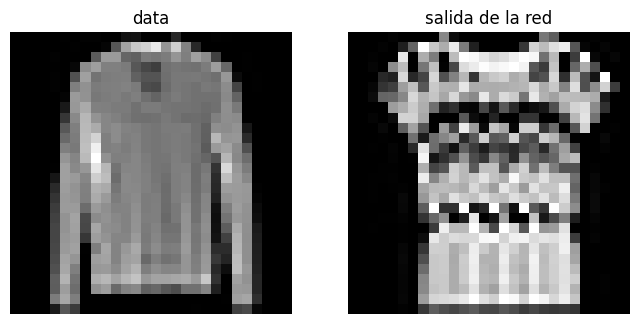

In [ ]:
# Las etiquetas son
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Cada dataset puede ser indexado.
figure = plt.figure(figsize=(8, 8))
cols = 2
#for i in range(1, cols+1):
#  sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
#  img, label = train_dataset[1215]
#  figure.add_subplot(1, cols, i)
#  plt.title("data")
#  plt.axis("off")
#  plt.imshow(img.squeeze(), cmap="gray")

sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
img, label = train_dataset[1215]
figure.add_subplot(1, cols, 1)
plt.title("data")
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")

sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
img, label = train_dataset[1216]
figure.add_subplot(1, cols, 2)
plt.title("salida de la red")
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

plt.show()

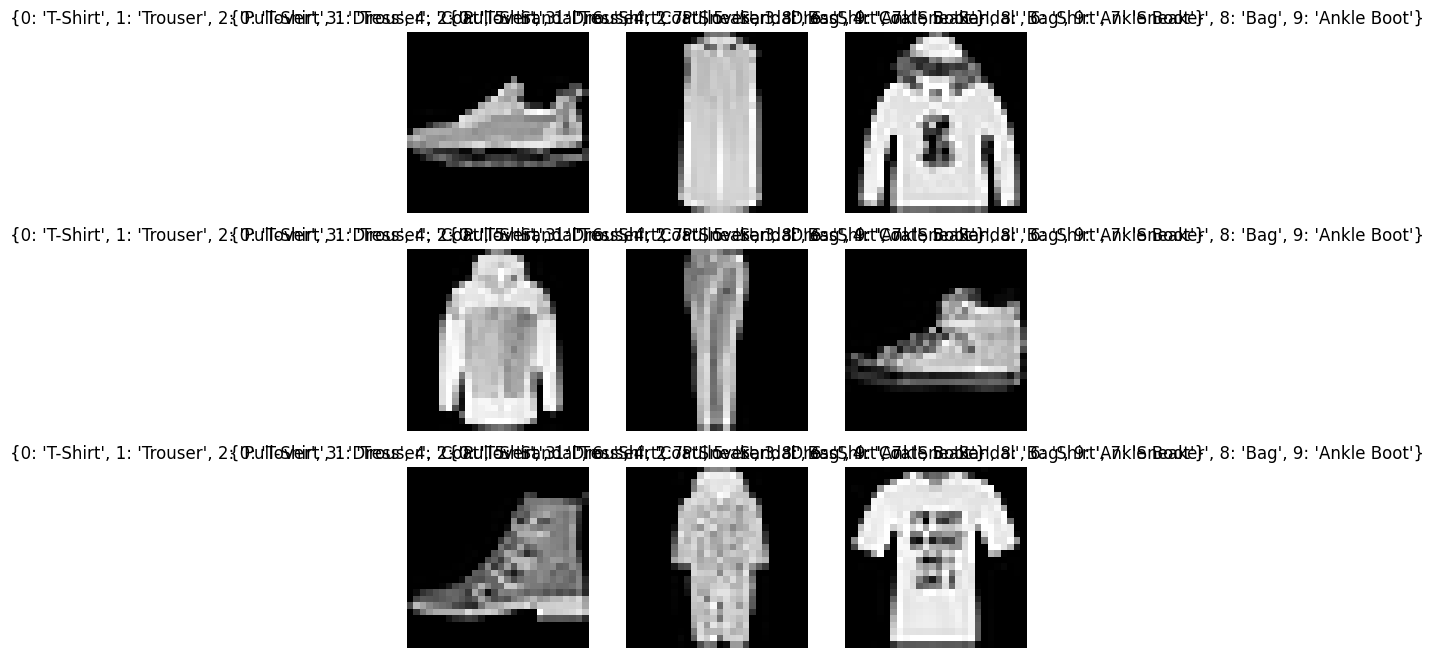

In [ ]:
# Las muestras de FashionMNIST consisten en imágenes en 256 escalas de grises de 28x28 píxeles cada una.
# Las imágenes constituyen prendas, calzados, etc.
# Cada imagen tiene asociado un etiqueta (label) que puede adoptar un valor de entre 10 opciones.
# Cada etiqueta representa una de las 10 categorías en las que las imágenes fueron clasificadas.
# El objetivo es aprender a clasificar éstas imágenes de acuerdo a las etiquetas asociadas.

# Las etiquetas son
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Cada dataset puede ser indexado.
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    #plt.title(labels_map[label])
    plt.title(labels_map)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Parte 2

Entrenando el autoencoder

Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).



In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimimos el progreso...
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")


Implemente, en una función, un loop de validación (o prueba) que recorra los batchs.


In [ ]:
# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    num_samples  = 0
    num_batches  = 0
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.
    model = model.to(device)
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            num_batches += 1
            avrg_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            num_samples += y.size(0)
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [ ]:
# entrenamos iterando sobre épocas
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Inicialize dos DataLoaders llamados train_loader y valid_loader que estén definidos sobre el
train_set (conjunto de entranmiento) y el valid_set (conjunto de validación) de Fashion-MNIST,
respectivamente, y que usen batchs de 100 ejemplos.

In [ ]:
# Definimos hiperparámetros de entrenamiento
learning_rate = 1e-3
batch_size = 100
num_epochs = 100
num_k = 1 #72
n=64 # Recordar que 28*28=784
dropouts=[0.1,0.3,0.5]

# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()


Cree una función de pérdida usando el Error Cuadrático Medio (ECM).

In [ ]:
# Creamos una funcion de perdida
loss_fn = nn.CrossEntropyLoss()

Cree un optimizador con un learning rate igual a 10−3 . Pruebe con ADAM

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

Cree una instancia del modelo con n = 64 neuronas en la capa intermedia y dropout p = 0,2.

Especifique en que dispositivo (device) va a trabajar: en una CPU o en una GPU

In [ ]:
#Como siempre chequeamos que este el GPU o el CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


Implemente un loop de entrenamiento y validación que trabaje con el train_loader y el valid_loader
respectivamente, usando un número arbitrario de épocas. Este loop debe guardar en dos listas los valores
de los promedios del ECM sobre el conjunto de entrenamiento y el de validación, respectivamente.
IMPORTANTE: No olvide copiar los batchs al dispositivo de trabajo.


Entrene y valide el modelo.


In [ ]:
p=0.5

i = 0
for n in sizes:
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


    model = Network(p,n)
    loss_fn = nn.MSELoss() # Para autoencoder
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

    list_avg_train_loss = []
    list_avg_test_train_loss = []
    list_avg_test_loss = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
        avg_test_train_loss = test_loop(trainloader,model,loss_fn)
        avg_test_loss = test_loop(testloader,model,loss_fn)
        list_avg_train_loss.append(avg_train_loss)
        list_avg_test_train_loss.append(avg_test_train_loss)
        list_avg_test_loss.append(avg_test_loss)



    train_loss[i,:] = list_avg_train_loss
    test_train_loss[i,:] = list_avg_test_train_loss
    test_loss[i,:] = list_avg_test_loss

    i = i+1

    print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 784])) that is different to the input size (torch.Size([100, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (28) must match the size of tensor b (784) at non-singleton dimension 3

In [ ]:
# Simulamos por tramos porque google colab se desconecta antes de que concluya para todos los valores de n en la lista.
for p in dropouts:
#for k in range(num_k):
    # Creamos el modelo y el optimzador
    model = Network(p,n)
    # Creamos los dataloaders ...
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    # ... en particular, usamos el dataset de prueba (test) como dataset de validación
    valid_dataloader = DataLoader(test_dataset,batch_size=batch_size)
    #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
    # Entrenamos el modelo y calcualmos curvas.
    min_valid_loss = float("inf")
    for epoch in range(num_epochs):
        train_loop(train_dataset,model,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_dataset,model,loss_fn)
        print(f"n={n} p={p} epoch={epoch} train_loss={train_loss} train_accu={train_accu}")
        df = df.append({"n":n,
                        "p":p,
                        "epoch":epoch,
                        "train_loss":train_loss,
                        "train_accu":train_accu}
                        ,ignore_index=True)
json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
#if COLAB:
#    files.download(json_fname)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x25 and 800x64)

In [ ]:
print(df)

In [ ]:
df.info()

In [ ]:
pred_imagen(testset, 'tirada2/remerafinal', epoch, sample_index= 1214, compare=True, show=True)

Use las listas del inciso anterior para graficar en función de las épocas el ECM de entrenamiento
y validación. Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

In [ ]:
fig,axes=plt.subplots(1,1)
fig.set_size_inches(12.0,8)
line_colors= ['navy','darkgreen','indigo', 'maroon']
dot_colors = ['skyblue', 'lightgreen','thistle','salmon']

for i in [0,1,2,3]:
    x = range(0,num_epochs)
    ax = axes
    ax.set_xlabel("Época")
    ax.set_ylabel("Error Cuadrático Medio (MSE)")
    ax.plot(x,train_loss[i,25:],label=f"entrenamiento n={sizes[i]}", color = dot_colors[i], linewidth=2)
    ax.plot(x,valid_loss[i,25:],label=f"validación n={sizes[i]}",color = line_colors[i],linestyle='--', linewidth=2)
    #ax.plot(x,test_train_loss[i,:],label=f"validación n={n}",color='black',linestyle='--')
    ax.legend()
    #ax = axes[1]
    #ax.set_xlabel("epoch")
    #ax.set_ylabel("accuracy")
    #ax.plot(x,dfn["train_accu"],label=f"train n={n}",color=color)
    #ax.plot(x,dfn["valid_accu"],label=f"
    # t
    # est n={n}",color='black',linestyle='--')
    #ax.legend()
fig.tight_layout()

for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(20)

for item in ([] +ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.savefig('test.png')
plt.show()

Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el
modelo entrenado.


Repita para otros valores de n, el optimizador GPU, otros valores de dropout, otros valores de
learning-rate, otros tamaños de batchs y cambiando las Sigmoids por ReLUs en la capa de salida.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

#PARTE 3

Definiendo y entrenando un clasificador convolucional reutilizando el encoder

Defina y cree un clasificador convolucional reutilizando el encoder del autoencoder convolucional
entrenado anteriormente. Más precisamente, el clasificador convolucional tiene que tener las siguientes
capas:
Primero, el encoder del autoencoder entrenado anteriormente. Este mapea una entrada de dimensiones
(1, 28, 28) a una salida de dimensión n.
Luego una capa lineal de clasificación compuesta:
* Una capa Linear que mapea dimensión (n, ) a dimensión (10, ).
* Una capa ReLU.
* Una capa Dropout.


In [ ]:
#Vuelvo a definir y uso los  pesos?
# O defino lo anterior por partes?

# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self,p=0.1):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)    #(1,28,28) a (16,26,26)
    #self.conv1 = nn.Conv2d(in_channels=1*28*28, out_channels=16*26*26, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    #self.conv2 = nn.Conv2d(in_channels=16*13*13, out_channels=32*11*11, kernel_size=3)


    self.fc1 = nn.Linear(in_features=32*5*5, out_features=n)  #(32∗5∗5) a n

    #Clasificador
    #self.fc2 = nn.Linear(in_features=n, out_features=32*5*5)  # n a (32∗5∗5)

    self.out = nn.Linear(in_features=n, out_features=10) # n a 10

    self.dropout = nn.Dropout(p)

  # define forward function
  def forward(self, t):
    #encoder

    # conv 1
    t = self.conv1(t)   #(1,28,28) a (16,26,26)
    t = F.relu(t)
    t = self.dropout(t)
    t = F.max_pool2d(t, kernel_size=2)   #(16,26,26) a (16,13,13)
    #t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)   #(16,13,13) a (32,11,11)
    t = F.relu(t)
    t = self.dropout(t)
    t = F.max_pool2d(t, kernel_size=2)   #(32,11,11) a (32,5,5)
    #t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.flatten()  #(32,5,5) a (32∗5∗5)
    t = self.fc1(t)     #(32∗5∗5) a n
    t = F.relu(t)
    t = self.dropout(t)


    #Clasificador

    #Linear y out
    # output
    t = self.out(t)   #n a 10
    t = F.relu(t)
    t = self.dropout(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t


In [ ]:
model = Network().to(device)
print(model)

NameError: name 'n' is not defined

Reimplemente las funciones con los loop de entrenamiento y validación adaptados para el problema
de clasificación (i.e. hay que incorporarles el cálculo de la precisión).

 Cree una función de pérdida usando la Cross Entropy Loss (CEL).

Cree un optimizador con un learning rate igual a 10−3 . Pruebe con ADAM.

Cree una instancia del modelo con n = 64 neuronas en la capa intermedia y dropout p = 0,2.

Especifique en que dispositivo (device) va a trabajar: en una CPU o en una GPU.

Implemente un loop que itere sobre épocas de entrenamiento y validación, y que correspondiente-
mente guarde en cuatro listas los valores de los promedios de la CEL y la Precisión en función de las
épocas para cada conjunto.


Entrene y valide el modelo.


Use las listas del inciso 3.7) para graficar en función de las épocas la CEL y la Precisión de
entrenamiento y validación, respectivamente. Discuta y comente, cual es el número óptimo de épocas
de entrenamiento?


In [ ]:
df3 = df1.pivot_table(index=["epoch"],aggfunc="mean").reset_index()
df3

In [ ]:
fig,axes=plt.subplots(2,1)
fig.set_size_inches(5.0,10.0)
colors = cm.Dark2.colors
#for color,p in zip(colors,df["p"].unique()):
#    dfn = df3[df3["p"]==p]
x = df3["epoch"]
ax = axes[0]
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.plot(x,df3["train_loss"],label=f"train",color="mediumslateblue")
ax.plot(x,df3["valid_loss"],label=f"valid",color="mediumslateblue",linestyle='--')
ax.legend()
ax = axes[1]
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.plot(x,df3["train_accu"],label=f"train",color="mediumslateblue")
ax.plot(x,df3["valid_accu"],label=f"valid",color="mediumslateblue",linestyle='--')
ax.legend()
fig.tight_layout()
plt.savefig("optimCNN.pdf")
plt.show()

Utilice el conjunto de validación para calcular una Matriz de confusión. Grafı́quela y comente
los resultados.

Repita para otros valores de n, el optimizador SGD, otros valores de dropout, otros valores de
learning-rate, otros tamaños de batchs y cambiando las Sigmoids por ReLUs en la capa de salida.
Pruebe, además, modificando el optimizador para que sólo reentrene los parámetros de la capa clasifica-
dora, dejando los parámetros de la capa codificadora tal como los deja el autoencoder convolucional. Que
valores/opciones de estos hiperparámetros considera los más convenientes? Porqué

In [ ]:
def plot_img(data, idx):

    #grafica un ejemplo
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(example):

    #muestra la prediccion para un ejemplo

    model.eval()
    x, y = test_dataset[example][0], test_dataset[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = sorted.values[0]
    indices = sorted.indices[0]
    print(
        f"Etiqueta correcta: {labels_map[y]}" ,
        end= "\n----------------------\n"
    )
    print("Etiqueta          Probabilidad")
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f"{label_pred:13}{v.item():.5f}")

In [ ]:
example = 4321
plot_img(test_dataset, example)
#plt.savefig('pullover.pdf')
show_prediction(example)